# Quantifying uncertainty in simulation results

## Introduction

The goal of this cookbook is to generate an uncertainty quantification report from a given calibration.
It takes a completed calibration as input, and outputs an exploratory trial, as well as a summary graph within the notebook.

### Steps

- Step 0: Select calibration of interest
- Step 1: Load the calibration and get the last completed version
- Step 2: Getting the maximum likelihood estimate (MLE)
- Step 3: Generate A Vpop
- Step 4: Create or update the exploratory Trial
- Step 5: Run and monitor the trial
- Step 6: Load and process the trial results

### Resources

- [Associated folder on jinko](https://jinko.ai/project/e0fbb5bb-8929-439a-bad6-9e12d19d9ae4?labels=e8479394-99ec-4297-83b7-e8b00511c185)


In [1]:
# Jinko specifics imports & initialization
# Please fold this section and do not edit it
import sys

sys.path.insert(0, "../lib")
import jinko_helpers as jinko

# Connect to Jinko (see README.md for more options)
jinko.initialize()

Authentication successful


In [2]:
# Cookbook specifics imports
import io
import uuid
import json
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import qmc
import zipfile
import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, minmax_scale

## Step 0: Select calibration of interest


In [3]:
""" 
Calibration short id can be retrieved from the URL of your calibration in Jinko, pattern is `https://jinko.ai/<calibration_short_id>`

WARNING: we cache the exploration trial ID such that subsequent runs of the notebook create new versions 
of the same Trial instead of new Trials each time.
When CHANGING the calibration of interest, you will want to delete the cache by restarting the kernel (there should be a "Restart" or "Restart kernel" button somewhere)
"""

calibration_short_id = "ca-pckt-0FOX"

# folder ID, pattern is `https://jinko.ai/project/<project_id>?labels=<folder_id>`
# This folder is where the exploratory Vpop and Trial will be saved, it does not have to be the same folder as that of
# the initial calibration
folder_id = "da41d151-af37-4c28-8e27-9f2a8ccf9895"

## Step 1: Pick the calibration version of interest

In [4]:
# Choose a specific revision. By default we return the last version
revision = None
# Choose a specific label. By default we return the last version
label = "cookbook"
response = jinko.get_project_item(
    sid=calibration_short_id, revision=revision, label=label
)
calibration_core_item_id, calibration_snapshot_id = (
    response["coreId"]["id"],
    response["coreId"]["snapshotId"],
)

# # Uncomment the following if you want to use the latest completed or stopped version
# response = jinko.get_latest_calib_with_status(shortId=calibration_short_id, statuses=["completed", "stopped"])
# calibration_core_item_id, calibration_snapshot_id = response["coreItemId"], response["snapshotId"]

print(
    f"Picked Calibration with coreItemId: {calibration_core_item_id}, snapshotId: {calibration_snapshot_id}"
)

calibration_inputs = jinko.make_request(
    f"/core/v2/calibration_manager/calibration/{calibration_core_item_id}/snapshots/{calibration_snapshot_id}",
).json()
parameters = [p["id"] for p in calibration_inputs["parameters"]]
parameter_map = {p["id"]: p for p in calibration_inputs["parameters"]}
display(calibration_inputs["solvingOptions"])
display(calibration_inputs["solvingOptionsOverride"])

Picked Calibration with coreItemId: 8d93ea4d-58f5-4bfc-8d37-a39a04471e36, snapshotId: 76468346-e303-46dc-8ee2-4ba19a9a6d28


{'allowVaryingStoichiometry': False,
 'coreVersion': '35.29.0',
 'discontinuityEvents': 'WarnOnly',
 'evaluator': 'LLVM',
 'extentUnits': 'mol',
 'inlineLimit': 1,
 'maxEvents': 100,
 'mutePhenomena': 'None',
 'muteVariables': 'None',
 'odeSolverAbsoluteTolerance': 1e-06,
 'odeSolverInitialStep': 1e-06,
 'odeSolverRelativeTolerance': 1e-06,
 'outputCompartments': {'Some': []},
 'outputParameters': {'Some': []},
 'outputRates': {'Some': []},
 'outputVariables': {'Some': []},
 'scoringMode': 'ScoringV2',
 'solver': 'BDF',
 'solvingTimes': [{'parentUuid': None,
   'tMax': 'P1M',
   'tMin': 'PT0S',
   'tStep': 'PT1H',
   'uuid': None}],
 'unitCheck': 'UnitCheckAndConvertAllSpeciesToExtentUnits'}

{'solvingTimes': [{'parentUuid': None,
   'tMax': 'P1M',
   'tMin': 'PT0S',
   'tStep': 'PT1H',
   'uuid': None}]}

## Step 2: Getting the maximum likelihood estimate (MLE)


In [5]:
response = jinko.make_request(
    "/core/v2/result_manager/calibration/sorted_patients",
    method="POST",
    json={
        "sortBy": "optimizationWeightedScore",
        "calibId": {
            "coreItemId": calibration_core_item_id,
            "snapshotId": calibration_snapshot_id,
        },
    },
)
response_summary = json.loads(response.content)
best_patient_index = response_summary[0]

# Get the list of scalars that we want to download, they correspond to the calibration objectives
objectives = jinko.make_request(
    f"/core/v2/calibration_manager/calibration/{calibration_core_item_id}/snapshots/{calibration_snapshot_id}/objectives_weights",
    method="GET",
).json()

response = jinko.make_request(
    "/core/v2/result_manager/calibration/scalar_result",
    method="POST",
    json={
        "select": None,
        "calibId": {
            "coreItemId": calibration_core_item_id,
            "snapshotId": calibration_snapshot_id,
        },
        "patientId": best_patient_index["patientNumber"],
    },
)
best_patient_raw = json.loads(response.content)
best_patient_values = list(
    filter(
        lambda x: x["indexes"]["scenarioArm"] == "crossArms",
        best_patient_raw["outputs"],
    )
)[0]["res"]
best_patient_parameters = {
    p["id"]: float(p["value"])
    for p in best_patient_values
    if p["type"]["type"] == "BaselineInput"
}
best_patient_scores = {
    s["id"]: s["value"]
    for results in best_patient_raw["outputs"]
    for s in results["res"]
    if (s["id"] in objectives.keys() or s["id"] == "optimizationWeightedScore")
}
mle = best_patient_scores["optimizationWeightedScore"]
print(
    f"Best patient corresponds to a maximum log-likelihood of {mle:.2g} (theoretical maximum is 1)"
)
print("All scores of the best patient:")
display(best_patient_scores)
best_patient_scores_trans = {
    k: np.exp(best_patient_scores[k] - 1) for k in best_patient_scores
}
print("Best patient descriptors:")
display(best_patient_parameters)

Best patient corresponds to a maximum log-likelihood of 0.77 (theoretical maximum is 1)
All scores of the best patient:


{'optimizationWeightedScore': 0.7718879705904726,
 'expected-Cmax-blood-drug-iv-5-10': 0.1470413900065557,
 'expected-Tmax-blood-drug-iv-5-10': 0.9867882150878603,
 'expected-Tmax-blood-drug-sc-1-30': 0.9556786703601108,
 'expected-Cmax-blood-drug-sc-1-30': 0.9980436069073638}

Best patient descriptors:


{'bloodFlowRate.tmin': 23.332515844364096,
 'kClearanceDrug.tmin': 0.06314866632865744,
 'lymphDrainingRate.tmin': 0.08991459464981938,
 'reflectionCoefficient.tmin': 3.090681773620929e-06}

## Step 3: Generate A Vpop

Here we generate an exploratory Vpop without going through any Vpop Design.


In [6]:
def to_patient(x):
    return {
        "patientIndex": str(uuid.uuid4()),
        "patientCategoricalAttributes": [],
        "patientAttributes": [{"id": p, "val": x[j]} for j, p in enumerate(parameters)],
    }


# Defines the low and high bounds to explore for each parameter which is not in the "custom_range" map
low_multiply = 1 / 2  # multiplies the MLE value to get the low bound
high_multiply = 2  # multiplies the MLE value to get the high bound

# Set custom ranges and logscale here. Simply add a new entry for each parameter that needs to be tweaked
# Log scale is in base 10
custom_range = {
    "kClearanceDrug": {"logscale": True, "min": -3, "max": 0},
    "bloodFlowRate": {"logscale": False, "min": 1, "max": 50},
}


def parameter_low_bound(param_name):
    p = parameter_map[param_name]
    if (
        param_name in custom_range.keys()
        and custom_range[param_name]["min"] is not None
    ):
        return custom_range[param_name]["min"]
    elif p["minBound"] is not None:
        return max(
            best_patient_parameters[f"{param_name}.tmin"] * low_multiply, p["minBound"]
        )
    else:
        return best_patient_parameters[f"{param_name}.tmin"] * low_multiply


def parameter_high_bound(param_name):
    p = parameter_map[param_name]
    if (
        param_name in custom_range.keys()
        and custom_range[param_name]["max"] is not None
    ):
        return custom_range[param_name]["max"]
    elif p["maxBound"] is not None:
        return min(
            best_patient_parameters[f"{param_name}.tmin"] * high_multiply, p["maxBound"]
        )
    else:
        return best_patient_parameters[f"{param_name}.tmin"] * high_multiply


"""
First we generate an exploratory Vpop using Sobol sequences to sample from the [-50%, +50%] hypercube
around the MLE parameter values
"""
# The size of the exploratory Vpop is 2^m, e.g. vpop size is 1024 for m=10
m = 10

d = len(parameters)
sampler = qmc.Sobol(d, scramble=False)
samples = sampler.random_base2(m)
samples = qmc.scale(
    samples,
    [parameter_low_bound(param_name) for param_name in parameters],
    [parameter_high_bound(param_name) for param_name in parameters],
)
# Handle log scaled parameters
for j, param_name in enumerate(parameters):
    if (
        param_name in custom_range.keys()
        and custom_range[param_name]["logscale"] == True
    ):
        samples[:, j] = np.exp(np.log(10) * samples[:, j])
exploratory_vpop = [to_patient(x) for x in samples]

"""
Then we generate a "tensorized" Vpop where, for each parameter p_i, we linearly sample on the [-50%, +50%]
interval while keeping p_j,j/=i fixed to the MLE values
"""
# how many samples in the search interval
n = 21

patient_groups = {}
tensor_vpop = []
for param_name in parameters:
    param_vals = np.linspace(
        parameter_low_bound(param_name), parameter_high_bound(param_name), n
    )
    if (
        param_name in custom_range.keys()
        and custom_range[param_name]["logscale"] == True
    ):
        param_vals = np.exp(np.log(10) * param_vals)
    all_vals = [
        [
            x if p == param_name else best_patient_parameters[f"{p}.tmin"]
            for p in parameters
        ]
        for x in param_vals
    ]
    patients = [to_patient(x) for x in all_vals]
    patient_groups[param_name] = set(patient["patientIndex"] for patient in patients)
    tensor_vpop += patients

"""
We assemble a map from patient_id to a 'label' which is either one of the parameters IDs in which case the 
patient belongs to the 1-D grid associated with that parameter. Or 'label' is 'multi' in which case the patient belongs 
to the "exploratory" Vpop where all parameters vary simultaneously.
"""
patient_map = {}
for param_name, id_set in patient_groups.items():
    for patient_id in id_set:
        patient_map[patient_id] = param_name
for patient in exploratory_vpop:
    patient_map[patient["patientIndex"]] = "multi"

# We merge both Vpops, we will later use 'patient_map' to split the Vpop results
vpop = {"patients": tensor_vpop + exploratory_vpop}


response = jinko.make_request(
    path="/core/v2/vpop_manager/vpop",
    method="POST",
    json=vpop,
    options={
        "name": "Exploratory Vpop",
        "folder_id": folder_id,
    },
)
project_item_info = jinko.get_project_item_info_from_response(response)
vpop_core_item_id = project_item_info["coreItemId"]["id"]
vpop_snapshot_id = project_item_info["coreItemId"]["snapshotId"]

print(f"Generated a Vpop of {len(vpop["patients"])} patients")
print(f"Resource link: {jinko.get_project_item_url_from_response(response)}")

Generated a Vpop of 1108 patients
Resource link: https://jinko.ai/vp-XDqA-q1rm


201: {"coreItemId":"d849481b-1ef7-4972-b66c-68ee78d734b1","metadata":{"internal":{"contentHash":"3ae52b7051c6b66351d479e87adfb181c4db820a491301b61463337e49dbcce3","projectId":"e0fbb5bb-8929-439a-bad6-9e12d19d9ae4"},"public":{"descriptorCount":4,"patientCount":1108}},"snapshotId":"cb214720-7670-4f30-bbd9-da911be06c1f","warnings":[]}


## Step 4: Create or update the exploratory Trial


In [7]:
# If there's already a Trial ID in the cache, create a new version of the same Trial instead of creating a new one
# Restart the notebook kernel when changing calibrations.
if "trial_core_item_id" in globals() and "trial_snapshot_id" in globals():
    response = jinko.make_request(
        path=f"/core/v2/trial_manager/trial/{trial_core_item_id}/snapshots/{trial_snapshot_id}",
        method="PATCH",
        json={
            "vpopId": {"coreItemId": vpop_core_item_id, "snapshotId": vpop_snapshot_id}
        },
    )
else:
    trial_data = {
        "computationalModelId": calibration_inputs["computationalModelId"],
        "protocolDesignId": calibration_inputs["protocolDesignId"],
        "vpopId": {"coreItemId": vpop_core_item_id, "snapshotId": vpop_snapshot_id},
        "dataTableDesigns": calibration_inputs["dataTableDesigns"],
        "solvingOptions": calibration_inputs["solvingOptions"],
        "scoringDesignId": calibration_inputs["scoringDesignId"],
    }
    response = jinko.make_request(
        path="/core/v2/trial_manager/trial",
        method="POST",
        json=trial_data,
        options={
            "name": f"UQ for Calibration {calibration_short_id}",
            "folder_id": folder_id,
        },
    )

project_item_info = jinko.get_project_item_info_from_response(response)
trial_core_item_id = project_item_info["coreItemId"]["id"]
trial_snapshot_id = project_item_info["coreItemId"]["snapshotId"]

print(f"Resource link: {jinko.get_project_item_url_from_response(response)}")

trial_inputs = jinko.make_request(
    f"/core/v2/trial_manager/trial/{trial_core_item_id}/snapshots/{trial_snapshot_id}",
).json()

display(trial_inputs["solvingOptions"])
display(trial_inputs["solvingOptionsOverride"])

Resource link: https://jinko.ai/tr-hIzh-jEHq


201: {"coreItemId":"7689d54f-6359-4144-bee4-40c32d82bd9a","metadata":{"internal":{"contentHash":"b5a1c92b38c9ce3d142e392ec6731c75f05fe8ec2911eccb8f1b23b8573d1854","solveScoreVpopUuid":null,"status":"not_launched"},"public":{"armCount":3,"patientCount":1108}},"snapshotId":"8d235abc-8bb0-4484-8623-991ea8c7eb26","warnings":[]}


{'allowVaryingStoichiometry': False,
 'coreVersion': '35.29.0',
 'discontinuityEvents': 'WarnOnly',
 'evaluator': 'LLVM',
 'extentUnits': 'mol',
 'inlineLimit': 1,
 'maxEvents': 100,
 'mutePhenomena': 'None',
 'muteVariables': 'None',
 'odeSolverAbsoluteTolerance': 1e-06,
 'odeSolverInitialStep': 1e-06,
 'odeSolverRelativeTolerance': 1e-06,
 'outputCompartments': {'Some': []},
 'outputParameters': {'Some': []},
 'outputRates': {'Some': []},
 'outputVariables': {'Some': []},
 'scoringMode': 'ScoringV2',
 'solver': 'BDF',
 'solvingTimes': [{'parentUuid': None,
   'tMax': 'P1M',
   'tMin': 'PT0S',
   'tStep': 'PT1H',
   'uuid': None}],
 'unitCheck': 'UnitCheckAndConvertAllSpeciesToExtentUnits'}

{'allowVaryingStoichiometry': False,
 'discontinuityEvents': 'WarnOnly',
 'evaluator': 'LLVM',
 'extentUnits': 'mol',
 'inlineLimit': 1,
 'maxEvents': 100,
 'mutePhenomena': 'None',
 'muteVariables': 'None',
 'odeSolverAbsoluteTolerance': 1e-06,
 'odeSolverInitialStep': 1e-06,
 'odeSolverRelativeTolerance': 1e-06,
 'outputCompartments': {'Some': []},
 'outputParameters': {'Some': []},
 'outputRates': {'Some': []},
 'outputVariables': {'Some': []},
 'scoringMode': 'ScoringV2',
 'solver': 'BDF',
 'solvingTimes': [{'parentUuid': None,
   'tMax': 'P1M',
   'tMin': 'PT0S',
   'tStep': 'PT1H',
   'uuid': None}],
 'unitCheck': 'UnitCheckAndConvertAllSpeciesToExtentUnits'}

## Step 5: Run and monitor the trial


In [8]:
# https://doc.jinko.ai/api/#/paths/core-v2-trial_manager-trial-trialId--snapshots--trialIdSnapshot--run/post
response = jinko.make_request(
    path=f"/core/v2/trial_manager/trial/{trial_core_item_id}/snapshots/{trial_snapshot_id}/run",
    method="POST",
)
jinko.monitor_trial_until_completion(trial_core_item_id, trial_snapshot_id)

Query successfully done, got a 204 response
Trial Progress: 100%|██████████| 3324/3324 [07:25<00:00,  7.46tasks/s] 

Job succeeded.


,Arm,countError,countPending,countSuccess
0,iv-5-10,0,0,1108
1,sc-1-10,0,0,1108
2,sc-1-30,0,0,1108


## Step 6: Load and process the trial results


In [9]:
# Retrieve result summary (https://doc.jinko.ai/api/#/paths/core-v2-trial_manager-trial-trialId--snapshots--trialIdSnapshot--results_summary/get)
response = jinko.make_request(
    f"/core/v2/trial_manager/trial/{trial_core_item_id}/snapshots/{trial_snapshot_id}/results_summary",
    method="GET",
)
responseSummary = json.loads(response.content)

# Print a summary of the results content
print("Keys in the results summary:\n", list(responseSummary.keys()), "\n")
print("Number of available patients:\n", len(responseSummary["patients"]), "\n")
print("Available arms:\n", responseSummary["arms"], "\n")
print(
    "Available scalars:\n",
    [scalar["id"] for scalar in responseSummary["scalars"]],
    "\n",
)
print(
    "Available cross-arm scalars:\n",
    [scalar["id"] for scalar in responseSummary["scalarsCrossArm"]],
    "\n",
)
print(
    "Available categorical parameters:\n",
    [scalar["id"] for scalar in responseSummary["categoricals"]],
    "\n",
)
print(
    "Available cross-arm categorical parameters:\n",
    [scalar["id"] for scalar in responseSummary["categoricalsCrossArm"]],
    "\n",
)


# Find baseline inputs, in other words the patients descriptors which were calibrated
patientDescriptors = [f"{p}.tmin" for p in parameters]

print("List of patient descriptors:\n", patientDescriptors, "\n")

resultScalars = list(objectives.keys()) + ["optimizationWeightedScore"]

print("List of result scalars:\n", resultScalars, "\n")

Keys in the results summary:
 ['coreVersion', 'patients', 'arms', 'scalars', 'scalarsCrossArm', 'categoricals', 'categoricalsCrossArm'] 

Number of available patients:
 1108 

Available arms:
 ['iv-5-10', 'sc-1-10', 'sc-1-30'] 

Available scalars:
 ['SimulationTMax', 'SimulationTMin', '__jinkoAllocationMiB.tmax', '__jinkoSolvingTime.tmax', 'dose.tmin', 'expected-Cmax-blood-drug-iv-5-10', 'expected-Cmax-blood-drug-sc-1-30', 'expected-Tmax-blood-drug-iv-5-10', 'expected-Tmax-blood-drug-sc-1-30', 'fullDose.tmin', 'primingDose.tmin'] 

Available cross-arm scalars:
 ['bloodFlowRate.tmin', 'kClearanceDrug.tmin', 'lymphDrainingRate.tmin', 'lymphaticFlowRate.tmin', 'optimizationWeightedScore', 'reflectionCoefficient.tmin'] 

Available categorical parameters:
 ['administrationMode'] 

Available cross-arm categorical parameters:
 [] 

List of patient descriptors:
 ['reflectionCoefficient.tmin', 'lymphDrainingRate.tmin', 'kClearanceDrug.tmin', 'bloodFlowRate.tmin'] 

List of result scalars:
 ['ex

In [10]:
# Retrieve scalar results (https://doc.jinko.ai/api/#/paths/core-v2-result_manager-scalars_summary/post)

# replace here by the scalar ids list you want
idsForScalars = {"scalars": resultScalars, "descriptors": patientDescriptors}
csvScalars = {}


def retrieve_scalars(scalar_type):
    try:
        print("Retrieving %s..." % (scalar_type))
        response = jinko.make_request(
            "/core/v2/result_manager/scalars_summary",
            method="POST",
            json={
                "select": idsForScalars[scalar_type],
                "trialId": {
                    "coreItemId": trial_core_item_id,
                    "snapshotId": trial_snapshot_id,
                },
            },
        )
        if response.status_code == 200:
            print("%s retrieved successfully." % (scalar_type))
            archive = zipfile.ZipFile(io.BytesIO(response.content))
            filename = archive.namelist()[0]
            print(f"Extracted file: {filename}")
            csvScalars[scalar_type] = archive.read(filename).decode("utf-8")
        else:
            print(
                f"Failed to retrieve scalar results: {response.status_code} - {response.reason}"
            )
            response.raise_for_status()
    except Exception as e:
        print(f"Error during scalar results retrieval or processing: {e}")
        raise


retrieve_scalars("scalars")
retrieve_scalars("descriptors")

Retrieving scalars...
scalars retrieved successfully.
Extracted file: scalars-95003720-77e2-5991-be99-5b23eff346df.csv
Retrieving descriptors...
descriptors retrieved successfully.
Extracted file: scalars-95003720-77e2-5991-be99-5b23eff346df.csv


In [11]:
"""
Filter the results by keeping only patients whose 'optimizationWeightedScore' is GREATER THAN a given threshold
"""

weightedScoreThreshold = -1e33

# Loading scalars into a pandas DataFrame
dfScalars = pd.read_csv(io.StringIO(csvScalars["scalars"]))
# Renaming and filtering some columns
dfScalars = dfScalars.rename(columns={"value": "likelihood", "scalarId": "score"}).drop(
    columns=["unit", "armId"]
)
# handle scalar errors
dfScalars["likelihood"] = pd.to_numeric(
    dfScalars["likelihood"], downcast="float", errors="coerce"
)

print("\nRaw scalar results data (first rows):\n")
display(dfScalars.head())

# Load patients descriptors into a dataframe
dfDescriptors = pd.read_csv(io.StringIO(csvScalars["descriptors"]))
# Renaming and filtering
dfDescriptors = dfDescriptors.rename(
    columns={"value": "parameterValue", "scalarId": "parameterName"}
).drop(columns=["unit", "armId"])
# Remove the `.tmin` suffix to parameter names
dfDescriptors["parameterName"] = dfDescriptors["parameterName"].apply(
    lambda t: t.removesuffix(".tmin")
)
print("\nPatients descriptors (first rows):\n")
display(dfDescriptors.head())

# Filter on optimizationWeightedScore
dfPatients = dfScalars.loc[
    (dfScalars["score"] == "optimizationWeightedScore")
    & (dfScalars["likelihood"] > weightedScoreThreshold)
]["patientId"]
print(f"\nNumber of selected patients: {len(dfPatients)}")

# Final data set
# Merge the scalars and descriptors
dfFull = dfScalars.merge(dfDescriptors, how="inner", on=["patientId"])
# Filter the data set
dfFull = dfFull.loc[dfFull["patientId"].isin(dfPatients)]
# Apply a transformation to likelihood
dfFull["likelihoodTrans"] = dfFull["likelihood"].apply(lambda y: np.exp(y - 1))

# Label the rows depending on whether they belong to the "tensorized" sub-vpop or
# the "exploratory" sub-vpop
dfFull["label"] = dfFull["patientId"].apply(lambda patient_id: patient_map[patient_id])

print("\nMerged data set first 5 rows:\n")
display(dfFull.head())


Raw scalar results data (first rows):



,patientId,score,likelihood
0,00c7e0bd-447d-401c-869a-7344c4a40932,optimizationWeightedScore,-1.836719
1,00e24aa7-5c91-4d6e-b07b-bcedf958341a,optimizationWeightedScore,-24.569902
2,0156a8a5-f032-46b5-a8d6-c1fe6a9892d5,optimizationWeightedScore,-55.695503
3,016a8a7c-c6d0-4db0-8ef7-217e33025a67,optimizationWeightedScore,0.465799
4,019d476d-6733-41fc-8489-b1f7824d0438,optimizationWeightedScore,-0.276671



Patients descriptors (first rows):



,patientId,parameterName,parameterValue
0,00c7e0bd-447d-401c-869a-7344c4a40932,bloodFlowRate,3.153320
1,00e24aa7-5c91-4d6e-b07b-bcedf958341a,bloodFlowRate,16.743164
2,0156a8a5-f032-46b5-a8d6-c1fe6a9892d5,bloodFlowRate,31.720703
3,016a8a7c-c6d0-4db0-8ef7-217e33025a67,bloodFlowRate,30.333008
4,019d476d-6733-41fc-8489-b1f7824d0438,bloodFlowRate,21.719727



Number of selected patients: 1108

Merged data set first 5 rows:



,patientId,score,likelihood,parameterName,parameterValue,likelihoodTrans,label
0,00c7e0bd-447d-401c-869a-7344c4a40932,optimizationWeightedScore,-1.836719,bloodFlowRate,3.153320,5.861766e-02,multi
1,00c7e0bd-447d-401c-869a-7344c4a40932,optimizationWeightedScore,-1.836719,kClearanceDrug,0.089971,5.861766e-02,multi
2,00c7e0bd-447d-401c-869a-7344c4a40932,optimizationWeightedScore,-1.836719,lymphDrainingRate,0.069587,5.861766e-02,multi
3,00c7e0bd-447d-401c-869a-7344c4a40932,optimizationWeightedScore,-1.836719,reflectionCoefficient,0.000002,5.861766e-02,multi
4,00e24aa7-5c91-4d6e-b07b-bcedf958341a,optimizationWeightedScore,-24.569902,bloodFlowRate,16.743164,7.854752e-12,multi


## Step 7: Generate the uncertainty quantification report

This section generates a grid of individual scatter plots. Each plot shows an individual score value in the y-axis against an individual parameter value in the x-axis.

The rows of the grid correspond to different scores used in the calibration, with the first row being the `optimizationWeightedScore`.

The columns of the grid correspond to the different parameters in the calibration options. An option is available to display any of them with a log-scale.

Each plot contains

- A green-cross: this shows the position (parameter value - score value) of the best patient from the calibration
- A red-line: this shows the results of the single parameter sweep, for each considered parameter (depending on the facet). This is a very rough estimation of the likelihood profile in the direction of one parameter.
- A scatter plot of blue points: these are all the individual patients in the multi-dimensional exploration trial. This gives an idea of the shape of the likelihood landscape in multi-dimension. Keep in mind that this plot is affected by the curse of dimensionality, and if the required number of patients to precisely estimate the value of the likelihood increases exponentially with the number of parameters.

Parameter identifiability is associated to the "sharpness" of the likelihood profile around the maximal value.

![Output plot explained](resources/post_calibration_uq/explo-calib-uq.png)


['optimization<br>WeightedScor<br>e']

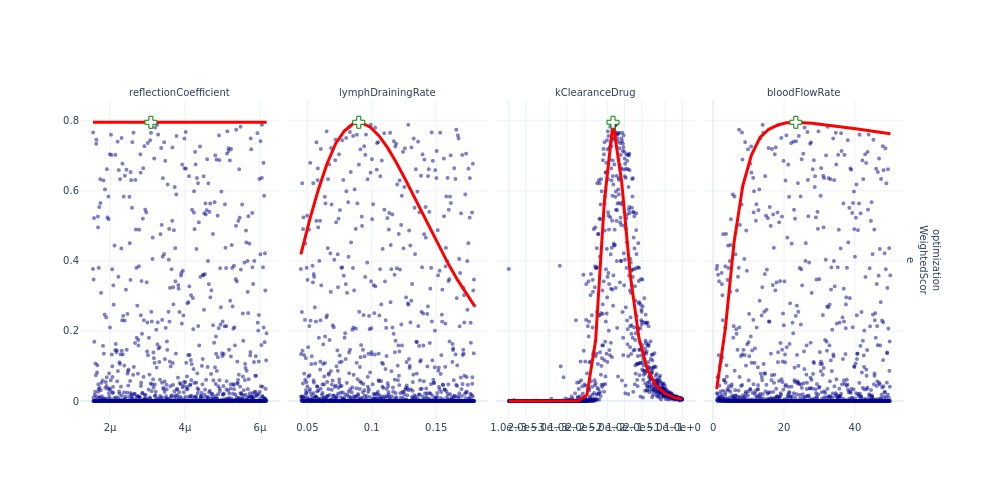

In [12]:
figureHeight = 500
figureWidth = 1000

scoreList = list(dfFull.score.unique())
scoreList.remove("optimizationWeightedScore")
scoreList = [
    "optimizationWeightedScore"
]  # + scoreList # uncomment to print all the calibration scores
nbScores = len(scoreList)

scoreListWrapped = ["<br>".join(textwrap.wrap(t, width=12)) for t in scoreList]
display(scoreListWrapped)

nbParams = len(parameters)
parametersWrapped = ["<br>".join(textwrap.wrap(t, width=30)) for t in parameters]

# Add here all params that should be displayed using a log scale
# By default, all params that had a custom range in log are selected
logParams = [p for p in custom_range if custom_range[p]["logscale"] == True]

fig = make_subplots(
    len(scoreList),
    len(parameters),
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.01,
    vertical_spacing=0.01,
    column_titles=parametersWrapped,
    row_titles=scoreListWrapped,
)
for i in range(nbScores):
    for j in range(nbParams):
        df = dfFull.loc[
            (dfFull["parameterName"] == parameters[j])
            & (dfFull["score"] == scoreList[i])
        ]
        scatter_df = df.loc[df["label"] == "multi"]
        fig.add_trace(
            go.Scatter(
                x=scatter_df["parameterValue"],
                y=scatter_df["likelihoodTrans"],
                mode="markers",
                marker=dict(size=4, color="darkblue", opacity=0.5),
                hoverinfo="none",
            ),
            row=i + 1,
            col=j + 1,
        )
        mono_df = df.loc[df["label"] == parameters[j]].sort_values(by="parameterValue")
        fig.add_trace(
            go.Scatter(
                x=mono_df["parameterValue"],
                y=mono_df["likelihoodTrans"],
                line_width=3,
                line_color="red",
            ),
            row=i + 1,
            col=j + 1,
        )
        fig.add_trace(
            go.Scatter(
                x=[best_patient_parameters[f"{parameters[j]}.tmin"]],
                y=[best_patient_scores_trans[scoreList[i]]],
                mode="markers",
                marker=dict(
                    size=10,
                    color="white",
                    symbol="cross",
                    line=dict(color="green", width=1),
                ),
            ),
            row=i + 1,
            col=j + 1,
        )
        if parameters[j] in logParams:
            fig.update_xaxes(type="log", row=i + 1, col=j + 1, tickformat=".1e")
fig.update_annotations(font_size=10)
fig.update_layout(
    font=dict(size=10),
    showlegend=False,
    width=figureWidth,
    height=figureHeight,
    template="plotly_white",
)
fig.show(renderer="jpeg")

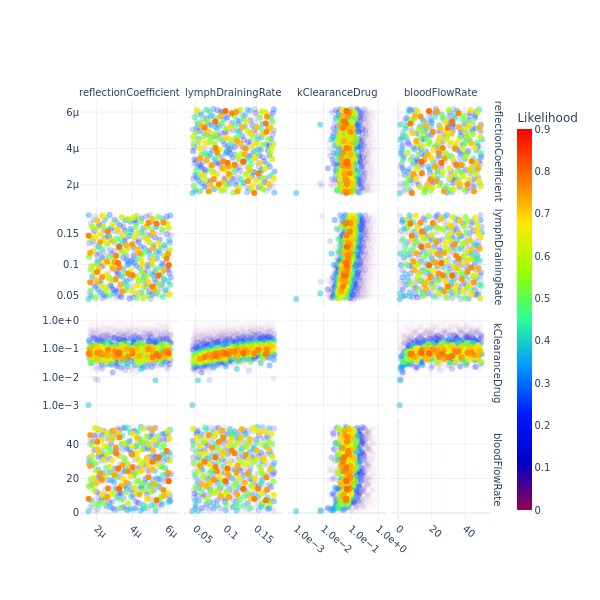

In [15]:
# Additional plot: pairwise correlation plots for calibrated parameters

# Add here all params that should be displayed using a log scale
# By default, all params that had a custom range in log are selected
logParams = [p for p in custom_range if custom_range[p]["logscale"] == True]

figureHeight = 600
figureWidth = 600

fig = make_subplots(
    len(parameters),
    len(parameters),
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.01,
    vertical_spacing=0.01,
    column_titles=parametersWrapped,
    row_titles=parametersWrapped,
)
for i in range(nbParams):  # iterating over rows
    for j in range(nbParams):  # iterating over columns
        if i == j:  # do not plot anything on the diagonal
            fig.add_trace(
                go.Scatter(x=[], y=[]),
                row=i + 1,
                col=j + 1,
            )
        else:
            df_j = dfFull.loc[
                (dfFull["parameterName"] == parameters[j])
                & (dfFull["score"] == "optimizationWeightedScore")
                & (dfFull["label"] == "multi")
            ]
            df_j = df_j[["parameterValue", "likelihoodTrans", "patientId"]].rename(
                columns={"parameterValue": parameters[j]}
            )
            df_i = dfFull.loc[
                (dfFull["parameterName"] == parameters[i])
                & (dfFull["score"] == "optimizationWeightedScore")
                & (dfFull["label"] == "multi")
            ]
            df_i = df_i[["parameterValue", "patientId"]].rename(
                columns={"parameterValue": parameters[i]}
            )

            scatter_df = df_j.merge(df_i, how="inner", on=["patientId"])
            scatter_df = scatter_df.sort_values(by="likelihoodTrans")
            fig.add_trace(
                go.Scatter(
                    x=scatter_df[parameters[j]],  # x axis is the column parameter
                    y=scatter_df[parameters[i]],  # y axis is the row parameter
                    mode="markers",
                    marker=dict(
                        size=6,
                        color=scatter_df["likelihoodTrans"],
                        opacity=(
                            scatter_df["likelihoodTrans"]
                            / scatter_df["likelihoodTrans"].max()
                        ),
                        coloraxis="coloraxis1",
                    ),
                    hoverinfo="none",
                ),
                row=i + 1,
                col=j + 1,
            )

        # Set the log scale for x and / or y axes
        if parameters[j] in logParams:
            fig.update_xaxes(type="log", row=i + 1, col=j + 1, tickformat=".1e")
        if parameters[i] in logParams:
            fig.update_yaxes(type="log", row=i + 1, col=j + 1, tickformat=".1e")
fig.update_annotations(font_size=10)
fig.update_xaxes(tickangle=40)
fig.update_coloraxes(
    colorbar_title="Likelihood",
    cmin=0,
    cmax=0.9,
    colorscale="Rainbow",
    colorbar_thickness=15,
)
fig.update_layout(
    font=dict(size=10),
    showlegend=False,
    # coloraxis_showscale=True,
    width=figureWidth,
    height=figureHeight,
    template="plotly_white",
)
fig.show(renderer="jpeg")

## Approximate the Hessian matrix of the likelihood

For the "best patient" to be at a local maximum likelihood, all Hessian matrix eigenvalues must be negative and the gradient must be zero.
See the "hessian_matrix.ipynb" cookbook for an example.

In [16]:
# Massage the data such that we have a matrix of samples of size (N, dim) and a vector of likelihood values of size N
df = dfFull.loc[
    (dfFull["label"] == "multi") & (dfFull["score"] == "optimizationWeightedScore")
]
pivot_df = df.pivot(index="patientId", columns="parameterName", values="parameterValue")

likelihood_df = df.groupby(by="patientId")["likelihood"].first().to_frame()
likelihood_df_sorted = likelihood_df.sort_values(by="patientId", ascending=False)
pivot_df_sorted = pivot_df.loc[likelihood_df_sorted.index]
unscaled_samples = pivot_df_sorted.values

# Scale the samples
# The centroid is the point in the paramter space corresponding to the MLE
unscaled_centroid = np.array(
    [
        best_patient_parameters[f"{param_name}.tmin"]
        for param_name in pivot_df_sorted.columns
    ]
)
unscaled_x = np.vstack((unscaled_samples, unscaled_centroid))
scaled_x = minmax_scale(unscaled_x, feature_range=(-0.1, 0.1))
samples, centroid = scaled_x[:-1, :], scaled_x[-1, :]
likelihood_values = likelihood_df_sorted.values
N, dim = samples.shape
distance_to_centroid = np.linalg.norm(samples - centroid, ord=2, axis=1)
x_order = np.argsort(distance_to_centroid)


# This function fits a quadratic model f(X) = X^TAX + BX + C to the likelihood
# The Hessian matrix of f(X) is 2A and its gradient is 2AX + B
def fit_quadratic_model(X, y):
    poly_reg = PolynomialFeatures(degree=2)
    quadratic_monomials = poly_reg.fit_transform(X)

    regressor = LinearRegression(
        fit_intercept=False
    )  # intercept is already accounted for by quadratic_monomials
    regressor.fit(quadratic_monomials, y)
    # The r2 score will be used to quantify the goodness of fit of the quadratic model
    r2_score = regressor.score(quadratic_monomials, y)

    # assemble the Hessian matrix and gradient
    H = np.zeros((dim, dim))
    g = np.zeros((dim,))
    regressor_coefs = regressor.coef_.flatten()
    for r, row in enumerate(poly_reg.powers_):
        c = regressor_coefs[r]
        if np.sum(row) == 2:
            (nonzeros,) = np.nonzero(row)
            if len(nonzeros) == 1:
                i = nonzeros[0]
                H[i, i] += c  # dfdxidxi = aii
                g[i] += 2 * c * centroid[i]  #
            elif len(nonzeros) == 2:
                i, j = nonzeros[0], nonzeros[1]
                H[i, j] += c / 2
                H[j, i] += c / 2
                g[i] += c * centroid[j]
                g[j] += c * centroid[i]
            else:
                print(f"Hey that's weird: {row}")
        elif np.sum(row) == 1:
            (nonzeros,) = np.nonzero(row)
            if len(nonzeros) == 1:
                i = nonzeros[0]
                g[i] += c
            else:
                print(f"Hey that's weird: {row}")
        else:  # degree 0 does not contribute to the Hessian
            continue
    return H, g, r2_score


H, gradient, r2_score = fit_quadratic_model(samples, likelihood_values)
eigen_decomposition = np.linalg.eig(H)
print(f"Hessian matrix:\n {H}")
print(f"Gradient:\n {gradient}")
print(f"Quadratic fit R2 score = {r2_score}")
h_df = pd.DataFrame(
    data=np.hstack(
        (
            np.reshape(eigen_decomposition.eigenvalues, (dim, 1)),
            eigen_decomposition.eigenvectors.T,
        )
    ),
    columns=["eigenValue"] + [f"x{k+1}" for k in range(dim)],
)
h_df = h_df.sort_values(by="eigenValue", ascending=True)
h_df

Hessian matrix:
 [[ 2.86615944e+02  3.79826337e+01  1.41951436e+01 -3.48037192e+00]
 [ 3.79826337e+01 -3.16302662e+03  5.59656236e+02 -2.50023804e+00]
 [ 1.41951436e+01  5.59656236e+02  2.66664443e+02 -1.90929354e-01]
 [-3.48037192e+00 -2.50023804e+00 -1.90929354e-01  5.35791411e+01]]
Gradient:
 [  -8.81237045  506.08598743 -114.70979822   -3.4706181 ]
Quadratic fit R2 score = 0.3634465191990871


,eigenValue,x1,x2,x3,x4
0,-3252.394417,-0.009968,0.987546,-0.157015,0.000727
3,53.528015,0.014937,-0.000424,0.001015,0.999888
1,281.623971,0.965291,-0.031409,-0.258894,-0.014171
2,361.075334,-0.260559,-0.154165,-0.953058,0.004794


## Analyze the quality of the approximation as a function of the number of samples


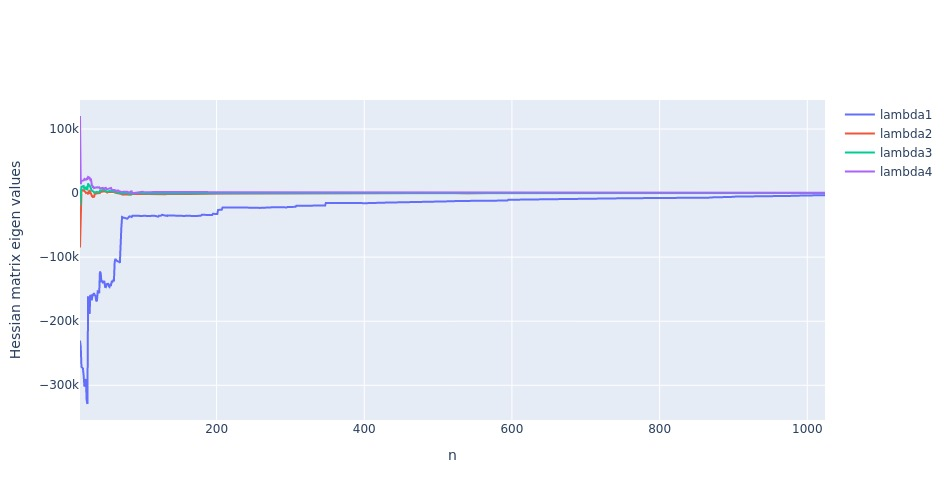

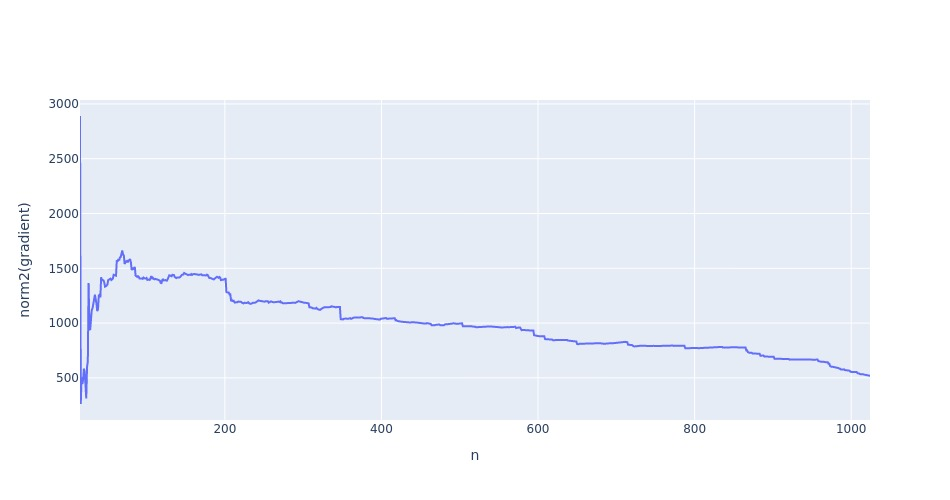

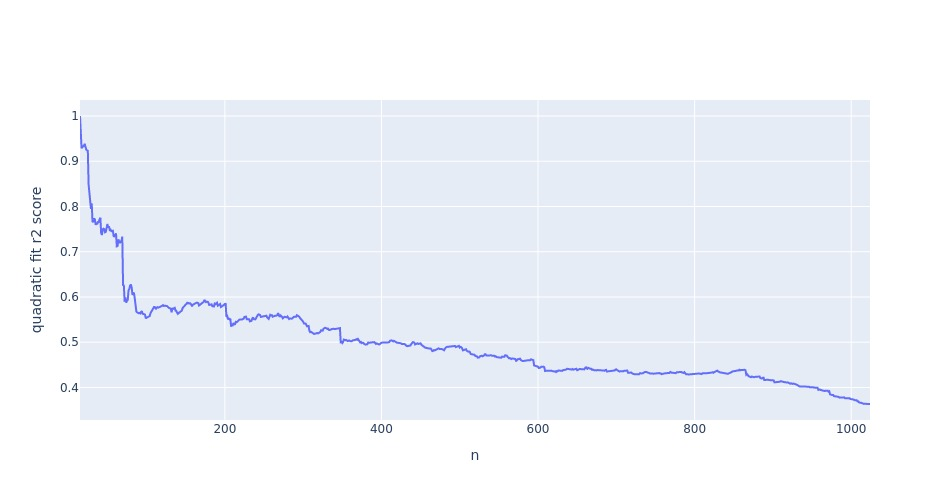

In [17]:
# How many points (minimum) do we need to fit a quadratic model?
poly_reg = PolynomialFeatures(degree=2)
quadratic_monomials = poly_reg.fit_transform(samples)
min_n = quadratic_monomials.shape[1]
if N < min_n:
    raise Exception(
        f"In dimension {dim}, one needs at least {min_n} points to fit a quadratic model, got {N} instead"
    )

# Compute and plot the Hessian eigen values, gradient and r2 score for each value of n
n_vector = np.arange(min_n, N + 1, 1)
eigenvalues = []
r2_scores = []
gradients = []
for n in n_vector:
    x = samples[x_order[:n], :]
    y = likelihood_values[x_order[:n]]
    H, gradient, r2_score = fit_quadratic_model(x, y)
    eigen_decomposition = np.linalg.eig(H)
    eigenvalues.append(np.sort(eigen_decomposition.eigenvalues))
    r2_scores.append(r2_score)
    gradients.append(np.linalg.norm(gradient, ord=2))
eigenvalues = np.array(eigenvalues)
n_vector
fig = go.Figure(
    go.Scatter(x=n_vector, y=eigenvalues[:, 0], name=f"lambda1", mode="lines")
)
for k in range(1, dim):
    fig.add_scatter(x=n_vector, y=eigenvalues[:, k], mode="lines", name=f"lambda{k+1}")
fig.update_layout(width=950, xaxis_title="n", yaxis_title="Hessian matrix eigen values")
fig.show(renderer="jpeg")

fig = go.Figure(go.Scatter(x=n_vector, y=gradients, mode="lines"))
fig.update_layout(width=950, xaxis_title="n", yaxis_title="norm2(gradient)")
fig.show(renderer="jpeg")

fig = go.Figure(go.Scatter(x=n_vector, y=r2_scores, mode="lines"))
fig.update_layout(width=950, xaxis_title="n", yaxis_title="quadratic fit r2 score")
fig.show(renderer="jpeg")